### reference 
1. https://github.com/jacobgil/keras-dcgan
2. https://github.com/Zackory/Keras-MNIST-GAN
3. https://oshearesearch.com/index.php/2016/07/01/mnist-generative-adversarial-model-in-keras/
4. https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
5. https://github.com/soumith/ganhacks

In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.intra_op_parallelism_threads = 44
config.inter_op_parallelism_threads = 44
sess = tf.Session(config=config)

from keras import backend as K
K.set_session(sess)

Using TensorFlow backend.


In [2]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist

# Discriminator
D = Sequential()
D.add(Conv2D(64, (5, 5), input_shape=(28, 28, 1), padding='same'))
D.add(Activation('tanh'))
D.add(MaxPooling2D(pool_size=(2, 2)))
D.add(Conv2D(128, (5, 5)))
D.add(Activation('tanh'))
D.add(MaxPooling2D(pool_size=(2, 2)))
D.add(Flatten())
D.add(Dense(1024))
D.add(Activation('tanh'))
D.add(Dense(1))
D.add(Activation('sigmoid'))
D.summary()

# compile
optimizer = SGD(lr=0.0005, momentum=0.9, nesterov=True)
D.compile(
    loss='binary_crossentropy', 
    optimizer=optimizer
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       204928    
_________________________________________________________________
activation_2 (Activation)    (None, 10, 10, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
__________

In [3]:
# Generator
G = Sequential()
G.add(Dense(input_dim=100, output_dim=1024))
G.add(Activation('tanh'))
G.add(Dense((128*7*7)))
G.add(BatchNormalization())
G.add(Activation('tanh'))
G.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
G.add(UpSampling2D(size=(2, 2)))
G.add(Conv2D(64, (5, 5), padding='same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('tanh'))
G.add(UpSampling2D(size=(2, 2)))
G.add(Conv2D(1, (5, 5), padding='same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('tanh'))
G.summary()

# compile
G.compile(
    loss='binary_crossentropy', 
    optimizer="SGD",
    metrics=['accuracy']
)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1024, input_dim=100)`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              103424    
_________________________________________________________________
activation_5 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
activation_6 (Activation)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
__________

In [4]:
# compile GAN
D.trainable = False
optimizer = SGD(lr=0.0005, momentum=0.9, nesterov=True)
GAN = Sequential()
GAN.add(G)
GAN.add(D)
GAN.compile(
    loss='binary_crossentropy', 
    optimizer=optimizer
)
D.trainable = True

('Epoch is', 0)
('Number of batches', 234)
batch 0 g_loss : 0.814700, d_loss : 0.874940
batch 50 g_loss : 1.065369, d_loss : 0.347474
batch 100 g_loss : 1.483082, d_loss : 0.416813
batch 150 g_loss : 1.709562, d_loss : 0.229357
batch 200 g_loss : 1.389348, d_loss : 0.276229


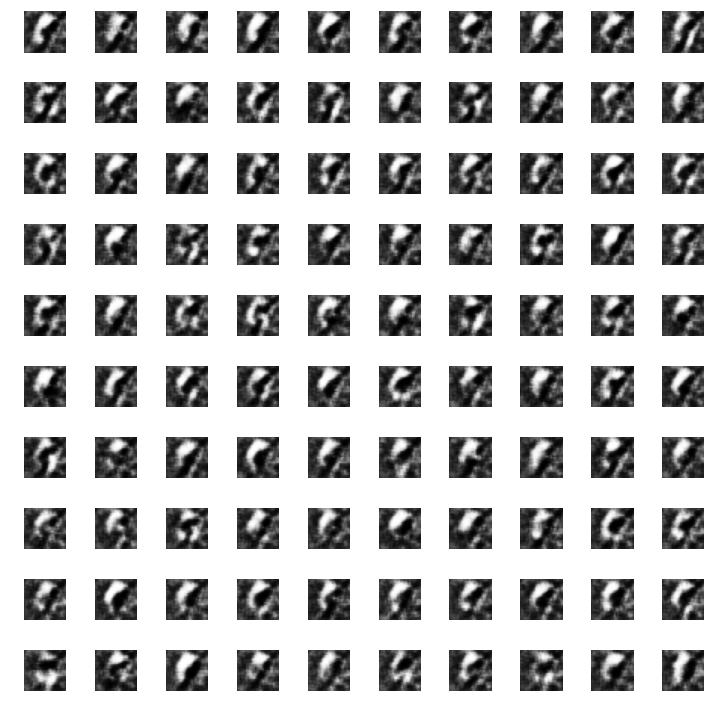

('Epoch is', 1)
('Number of batches', 234)
batch 0 g_loss : 1.484412, d_loss : 0.365607
batch 50 g_loss : 1.641847, d_loss : 0.320338
batch 100 g_loss : 1.525617, d_loss : 0.343088
batch 150 g_loss : 1.281887, d_loss : 0.384610
batch 200 g_loss : 1.319882, d_loss : 0.468825


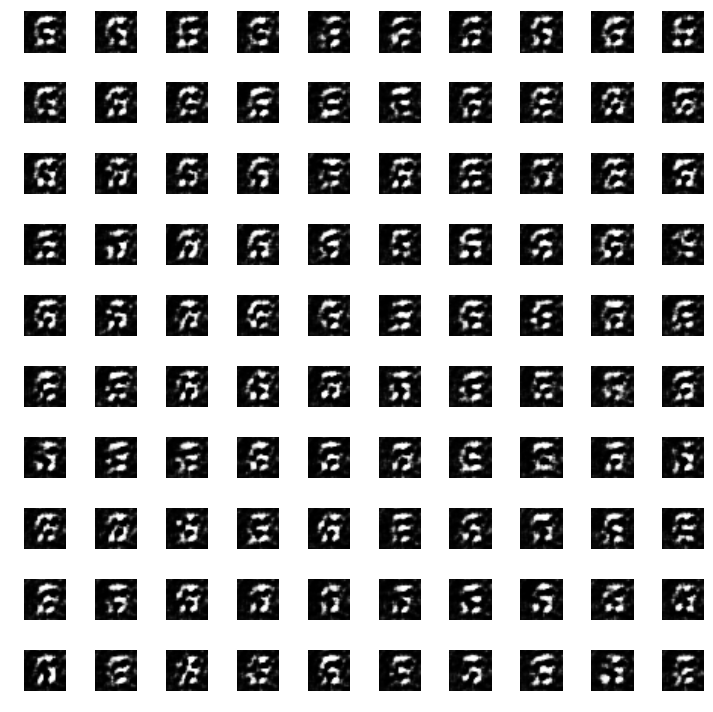

('Epoch is', 2)
('Number of batches', 234)
batch 0 g_loss : 1.173171, d_loss : 0.525435
batch 50 g_loss : 1.160212, d_loss : 0.499716
batch 100 g_loss : 1.131760, d_loss : 0.483776
batch 150 g_loss : 0.991698, d_loss : 0.516129
batch 200 g_loss : 1.029926, d_loss : 0.509707


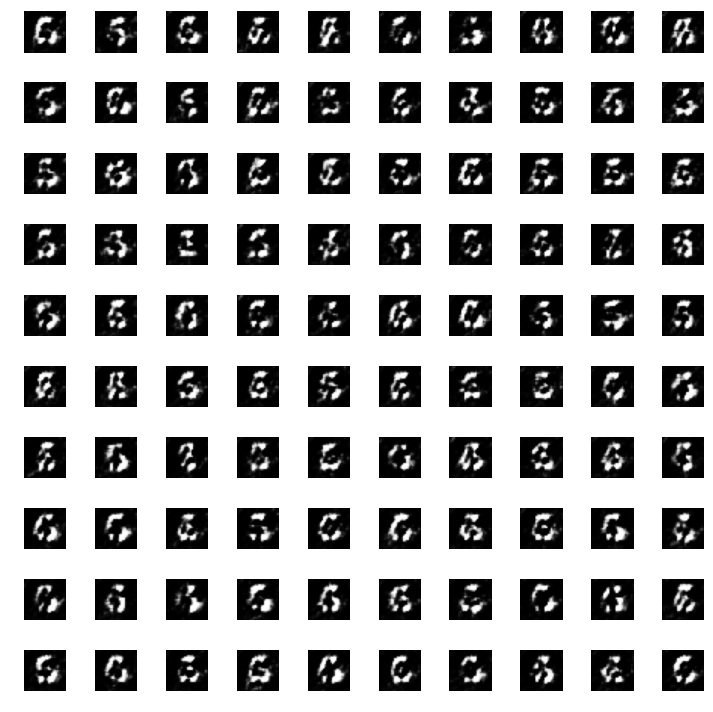

('Epoch is', 3)
('Number of batches', 234)
batch 0 g_loss : 1.013668, d_loss : 0.517674
batch 50 g_loss : 1.045198, d_loss : 0.509710
batch 100 g_loss : 1.055450, d_loss : 0.488905
batch 150 g_loss : 0.973858, d_loss : 0.531694
batch 200 g_loss : 0.916659, d_loss : 0.516313


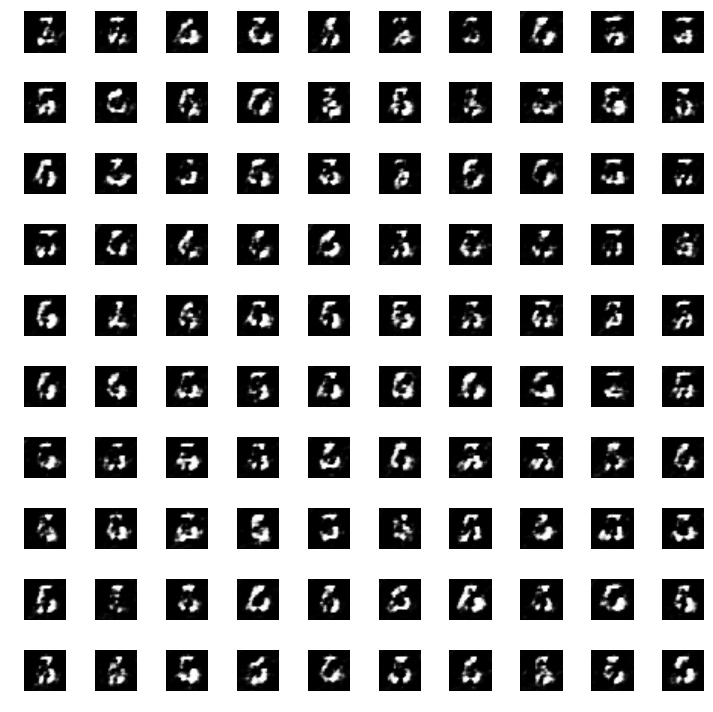

('Epoch is', 4)
('Number of batches', 234)
batch 0 g_loss : 1.090703, d_loss : 0.457553
batch 50 g_loss : 0.979394, d_loss : 0.494095
batch 100 g_loss : 1.104341, d_loss : 0.451395
batch 150 g_loss : 1.233066, d_loss : 0.489464
batch 200 g_loss : 1.349194, d_loss : 0.471834


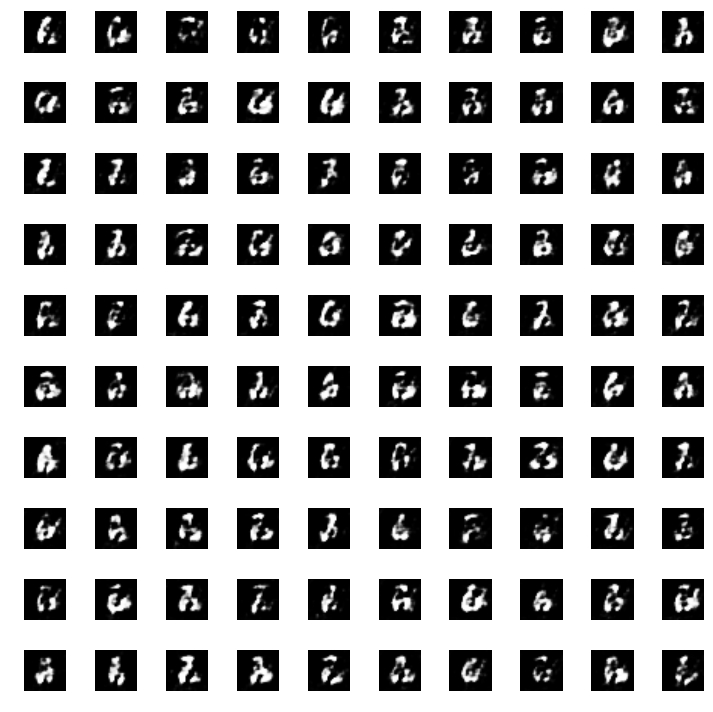

('Epoch is', 5)
('Number of batches', 234)
batch 0 g_loss : 1.702875, d_loss : 0.438690
batch 50 g_loss : 0.618731, d_loss : 0.578113
batch 100 g_loss : 1.375036, d_loss : 0.375539
batch 150 g_loss : 1.507512, d_loss : 0.355737
batch 200 g_loss : 1.256399, d_loss : 0.437194


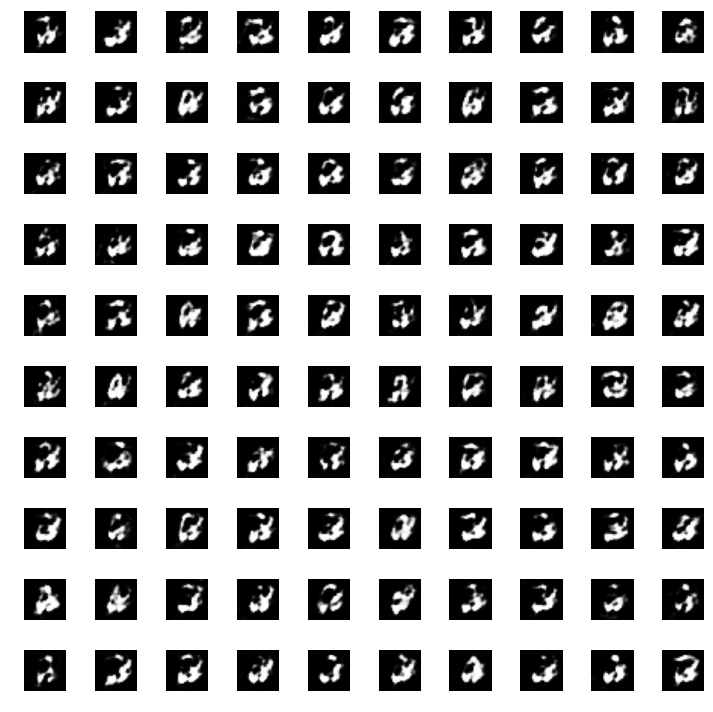

('Epoch is', 6)
('Number of batches', 234)
batch 0 g_loss : 1.167253, d_loss : 0.411363
batch 50 g_loss : 1.158714, d_loss : 0.405048
batch 100 g_loss : 2.012339, d_loss : 0.353285
batch 150 g_loss : 1.758866, d_loss : 0.411237
batch 200 g_loss : 1.541987, d_loss : 0.392458


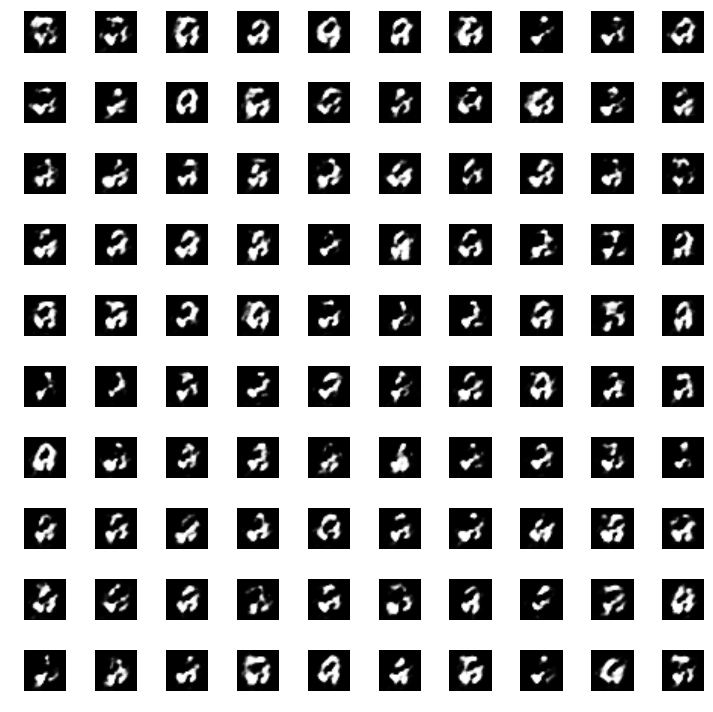

('Epoch is', 7)
('Number of batches', 234)
batch 0 g_loss : 2.329505, d_loss : 0.380415


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 376, in _fixed_getinnerframes
    lines = ulinecache.getlines(file)[start:end]
  File "/usr/local/lib/python2.7/site-packages/IPython/utils/ulinecache.py", line 37, in getlines
    return [l.decode(encoding, 'replace') for l in lines]
KeyboardInterrupt


IndexError: string index out of range

In [5]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, :, :, None]
X_test = X_test[:, :, :, None]

EPOCH = 20
BATCH_SIZE = 256

for EPOCH in range(100):
    print("Epoch is", EPOCH)
    print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
    for index in range(int(X_train.shape[0]/BATCH_SIZE)):
        # generate 256 fake images
        noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, 100))
        image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
        generated_images = G.predict(noise, verbose=0)
        # 256 fake image, 256 real images
        # training discriminator
        X = np.concatenate((image_batch, generated_images))
        y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
        d_loss = D.train_on_batch(X, y)
        # frezze discriminator then training generator 
        noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
        D.trainable = False
        g_loss = GAN.train_on_batch(noise, [1] * BATCH_SIZE)
        D.trainable = True
        if index % 50 == 0:
            print("batch %d g_loss : %f, d_loss : %f" % (index, g_loss, d_loss))
        
    try_input = np.random.rand(100, 100)
    preds = G.predict(try_input)
    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()